In [ ]:
import sys 
import torch
sys.path.append('../..')

import os
import pytorch_lightning as pl
from src.datasets.vqa_rad_dataset import VQRadDataModule
from src.models.multimodal.flamingo_module import FlamingoModule
from tqdm import tqdm

from pytorch_lightning import Trainer, seed_everything
import torchvision.transforms as T

from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning import loggers as pl_loggers

%load_ext autoreload
%autoreload 2

seed_everything(42, workers=True)

img_mean = (0.48,0.48,0.48)
img_std = (0.265,0.265,0.265)

transforms = {'train':
    T.Compose(
    [
        # T.RandomRotation(10),
        T.ToTensor(),
        # T.Normalize(mean=img_mean, std=img_std)
    ]),
    'val':
    T.Compose(
    [
        # T.RandomRotation(10),
        T.ToTensor(),
        # T.Normalize(mean=img_mean, std=img_std)
    ]),
    'test':
    T.Compose(
    [
        T.ToTensor(),
        # T.Normalize(mean=img_mean, std=img_std)
    ])
}


: 

In [51]:
# Hyperparameters
NUM_DATA_WORKERS  = 8
ONLY_IMAGES = False
BATCH_SIZE = 1
NUM_EPOCHS = 10
LIMIT_NUM_SAMPLES = None

ACCELERATOR = "gpu"
DEVICES = [4]
# ACCELERATOR = "cpu"
# DEVICES = 1
DATASET_ROOT = '/home/andrei/mlmi/home/mlmi-matthias/VQA-RAD'
PRETRAINED_CLIP_PATH = '/home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth'
PRETRAINED_GPT2_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin"
ANSWERS_LIST_PATH = '/home/andrei/mlmi/home/mlmi-matthias/VQA-RAD/unique_answers.pkl'

IMAGE_TYPE = "jpg"
SHUFFLE = True
TOKENIZER  = "gpt2"
LOAD_IN_MEM = True
PREPROCESSED = False

vqarad_datamodule = VQRadDataModule(
                                batch_size=BATCH_SIZE, transforms=transforms, root=DATASET_ROOT,
                                limit_num_samples=LIMIT_NUM_SAMPLES, num_workers=NUM_DATA_WORKERS, shuffle=SHUFFLE,
                                tokenizer="gpt2", preprocessed=PREPROCESSED, load_in_memory=LOAD_IN_MEM
)

Loading all images into memory... for train
Loaded from orig dataset: /home/andrei/mlmi/home/mlmi-matthias/VQA-RAD/images_preprocessed/*.jpg
Data in dict: 314
Loading all images into memory... for val
Loaded from orig dataset: /home/andrei/mlmi/home/mlmi-matthias/VQA-RAD/images_preprocessed/*.jpg
Data in dict: 314
Loading all images into memory... for test
Loaded from orig dataset: /home/andrei/mlmi/home/mlmi-matthias/VQA-RAD/images_preprocessed/*.jpg
Data in dict: 314


In [52]:
train_loader = vqarad_datamodule.train_dataloader()
val_loader = vqarad_datamodule.val_dataloader()
test_loader = vqarad_datamodule.test_dataloader()

In [29]:
# MODEL HPRAMS
VOCAB_SIZE_OF_TOKENIZER = 50257 # mimic_datamodule.train_dataset.tokenizer.vocab_size
LANGUAGE_MODEL = 'gpt2'
NUM_TOKENS = VOCAB_SIZE_OF_TOKENIZER +3 if LANGUAGE_MODEL=="gpt2" else 31092
FLAMINGO_EMBED_DIM = 768
DEPTH = 12
NUM_HEADS = 8
ATT_HEAD_DIM = 64
CROOS_ATT_EVERY=3
MEDIA_TOKEN_ID = vqarad_datamodule.train_dataset.tokenizer.\
    all_special_ids[vqarad_datamodule.train_dataset.tokenizer.all_special_tokens.index('<image>')]
PERCEIVER_NUM_LATENTS = 64
PERCEIVER_DEPTH = 2
IMAGE_ENCODER = "clip"



print("LANGUAGE_MODEL : ",LANGUAGE_MODEL, "\n"
        "NUM_TOKENS : ",NUM_TOKENS, "\n"
        "FLAMINGO_EMBED_DIM : ",FLAMINGO_EMBED_DIM, "\n"
        "DEPTH : ",DEPTH, "\n"
        "NUM_HEADS : ",NUM_HEADS, "\n"
        "ATT_HEAD_DIM : ",ATT_HEAD_DIM, "\n"
        "CROOS_ATT_EVERY : ",CROOS_ATT_EVERY, "\n"
        "MEDIA_TOKEN_ID : ",MEDIA_TOKEN_ID, "\n"
        "PERCEIVER_NUM_LATENTS : ",PERCEIVER_NUM_LATENTS, "\n"
        "PERCEIVER_DEPTH : ",PERCEIVER_DEPTH, "\n"
        "IMAGE_ENCODER : ",IMAGE_ENCODER, "\n"
        "PRETRAINED_CLIP_PATH : ",PRETRAINED_CLIP_PATH, "\n"
        "PRETRAINED_GPT2_PATH : ",PRETRAINED_GPT2_PATH, "\n")


hyperparams = {
    'pretrained_clip_path': PRETRAINED_CLIP_PATH,
    'warmup_steps': 0,
    'num_tokens': NUM_TOKENS,
    'dim': FLAMINGO_EMBED_DIM,
    'depth': DEPTH,
    'num_heads': NUM_HEADS,
    'dim_head': ATT_HEAD_DIM,
    'cross_attn_every': CROOS_ATT_EVERY,
    'media_token_id': MEDIA_TOKEN_ID,
    'perceiver_num_latents': PERCEIVER_NUM_LATENTS,
    'perceiver_depth': PERCEIVER_DEPTH,
    'image_encoder': IMAGE_ENCODER,
    'language_model': LANGUAGE_MODEL,
    'pretrained_gpt2_path': PRETRAINED_GPT2_PATH,
}


model = FlamingoModule(**hyperparams)

LANGUAGE_MODEL :  gpt2 
NUM_TOKENS :  50260 
FLAMINGO_EMBED_DIM :  768 
DEPTH :  12 
NUM_HEADS :  8 
ATT_HEAD_DIM :  64 
CROOS_ATT_EVERY :  3 
MEDIA_TOKEN_ID :  50258 
PERCEIVER_NUM_LATENTS :  64 
PERCEIVER_DEPTH :  2 
IMAGE_ENCODER :  clip 
PRETRAINED_CLIP_PATH :  /home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth 
PRETRAINED_GPT2_PATH :  /home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin 

Pretrained clip is being loaded
Flamingo is being initialized with  gpt2  as language model
GPT 2 Weights are loading...
Loaded GPT2 weights and Embeddings num_weights loaded :  156


In [30]:
# CHECKPOINT_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/flamingo_clip_GPT2_FT_vqaRAD_MIMICback_lr1e-4_Xray/checkpoints/epoch=5-val_loss=1.35-other_metric=0.00.ckpt"
CHECKPOINT_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/flamingo_clip_GPT2_FT_vqaRAD_MIMICback_all/checkpoints/epoch=59-val_loss=1.48-other_metric=0.00.ckpt"
# CHECKPOINT_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/flamingo_clip_GPT2_FT_vqaRAD_ROCOback_all/checkpoints/epoch=78-val_loss=1.53-other_metric=0.00.ckpt"

START_FROM_CHECKPOINT = True

if START_FROM_CHECKPOINT:
    print("Pretrained Flamingo Model is loaded from checkpoint : ",CHECKPOINT_PATH)
    model.load_state_dict(torch.load(CHECKPOINT_PATH)["state_dict"])

Pretrained Flamingo Model is loaded from checkpoint :  /home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/flamingo_clip_GPT2_FT_vqaRAD_MIMICback_all/checkpoints/epoch=59-val_loss=1.48-other_metric=0.00.ckpt


In [35]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
from transformers import GPT2Tokenizer
import numpy as np

from torch import nn as nn
import torch.nn.functional as F
def generate(image, context, cur_model, ntok=20):
    for _ in range(ntok):
        out = cur_model({'image': image,'input_ids': context })
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        next_tok = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        context = torch.cat([context, next_tok.unsqueeze(-1)], dim=-1)
    return context


tokenizer = vqarad_datamodule.train_dataset.tokenizer

In [53]:
# generate answer embeds
val_loader_iter = iter(val_loader)
test_loader_iter = iter(test_loader)

val_answer_embeds = dict()

# for val
for batch in tqdm(val_loader_iter):
    with torch.no_grad():
        model.eval()     
        ans = batch['answer'][0]
        if ans not in val_answer_embeds.keys():
            val_answer_embeds[ans] = torch.Tensor([])
        GT_answer =  torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer: '+ batch["answer"][0] + ' <EOC>')])
        pred_out_logits = model.forward({'image': batch['image'], 'input_ids': GT_answer}, return_embeds=True)
        val_answer_embeds[ans] = torch.cat([val_answer_embeds[ans], torch.mean(pred_out_logits, dim=1)])

test_answer_embeds = dict()

# for test
for batch in tqdm(test_loader_iter):
    with torch.no_grad():
        model.eval()     
        ans = batch['answer'][0]
        if ans not in test_answer_embeds.keys():
            test_answer_embeds[ans] = torch.Tensor([])
        GT_answer =  torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' answer: '+ batch["answer"][0] + ' <EOC>')])
        pred_out_logits  = model.forward({'image': batch['image'], 'input_ids': GT_answer}, return_embeds=True)
        test_answer_embeds[ans] = torch.cat([test_answer_embeds[ans], torch.mean(pred_out_logits, dim=1)])

# mean all possible answers for val
for key in tqdm(val_answer_embeds.keys()):
    if val_answer_embeds[key].shape[0] == 1:
        continue
    val_answer_embeds[key] = torch.mean(val_answer_embeds[key], dim=0).unsqueeze(0)

# mean all possible answers for test
for key in tqdm(test_answer_embeds.keys()):
    if test_answer_embeds[key].shape[0] == 1:
        continue
    test_answer_embeds[key] = torch.mean(test_answer_embeds[key], dim=0).unsqueeze(0)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 405/405 [00:50<00:00,  8.87it/s]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 225/225 [00:28<00:00,  8.46it/s]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 115/115 [00:00<00:00, 120105.82it/s]


In [54]:
val_answer_embeds['no'].shape

torch.Size([1, 768])

In [23]:
from torch import no_grad


def generate_logits(image, pred_context, model, ntok, batch):

    # get a prediction (whole answer)
    pred_out_logits = None
    pred_answer = torch.tensor([[]])
    for i in range(ntok):
        out = model.forward({'image': image,'input_ids': pred_context, 'targets': batch['targets']})
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        next_tok = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        pred_answer = torch.cat([pred_answer, next_tok.unsqueeze(-1)], dim=-1)
        pred_context = torch.cat([pred_context, next_tok.unsqueeze(-1)], dim=-1)

    with torch.no_grad():
        model.eval()
        # only get embeddings for answer and GT from the model
        answer = tokenizer.decode(pred_answer[pred_answer.int()!=50257].int())                # remove padding tokens, <EOC> token remains
        pred_out_logits = model.forward({'image': image,'input_ids': pred_context[pred_context!=50257].unsqueeze(0)}, return_embeds=True)

    return pred_context, pred_out_logits, answer

In [55]:
# do validation dataset eval
val_loader_iter = iter(val_loader)
n = len(val_loader)
print(f'validation dataset has {n} samples')

preds = torch.tensor([])
reals = torch.tensor([])

similarity_num = 0
identical_num = 0

for sample in tqdm(val_loader_iter):
    val_img = sample["image"]
    pred_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer:')]) 
    GT_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer: ' + sample["answer"][0] + '<EOC>')])
    out, pred_out_logits, answer = generate_logits(val_img, pred_context, model, ntok=20, batch=sample)

    # print(f'pred: {pred_out_logits.shape}\nreal: {real_out_logits.shape}')
    pred = torch.mean(pred_out_logits, dim=1)
    preds = torch.cat([preds,pred], dim=0)

    ans = answer.replace('<EOC>','')

    if sample["answer"][0].strip().lower() == ans.strip().lower():
        identical_num += 1

    multiples = [len(val_answer_embeds.keys()), 1]

    b = pred.tile(multiples)

    similarity_max = np.NINF
    answer = None
    for i, key in enumerate(val_answer_embeds.keys()):
        similarity = torch.nn.CosineSimilarity()(b[i], val_answer_embeds[key])
        if similarity_max < similarity:
            similarity_max = similarity
            answer = key

    if answer.strip().lower() in sample['answer'][0].strip().lower() or sample['answer'][0].strip().lower() in answer.strip().lower() or answer.strip().lower() == sample['answer'][0].strip().lower():
        similarity_num += 1
    

print(f'There were {similarity_num} TPs out of {n}')
print(f'There were {identical_num} identical answers out of {n}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

 50%|█████     | 204/405 [08:23<08:49,  2.64s/it]

In [ ]:
# do validation dataset eval
test_loader_iter = iter(test_loader)
n = len(test_loader)
print(f'validation dataset has {n} samples')

reals = torch.tensor([])

similarity_num = 0
identical_num = 0

for sample in tqdm(test_loader_iter):
    img = sample["image"]
    pred_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer:')]) 
    GT_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer: ' + sample["answer"][0] + '<EOC>')])
    out, pred_out_logits, answer = generate_logits(img, pred_context, model, ntok=20, batch=sample)

    # print(f'pred: {pred_out_logits.shape}\nreal: {real_out_logits.shape}')
    pred = torch.mean(pred_out_logits, dim=1)
    preds = torch.cat([preds,pred], dim=0)

    ans = answer.replace('<EOC>','')

    if sample["answer"][0].strip().lower() == ans.strip().lower():
        identical_num += 1

    multiples = [len(test_answer_embeds.keys()), 1]

    b = pred.tile(multiples)

    similarity_max = np.NINF
    answer = None
    for i, key in enumerate(test_answer_embeds.keys()):
        similarity = torch.nn.CosineSimilarity()(b[i], test_answer_embeds[key])
        if similarity_max < similarity:
            similarity_max = similarity
            answer = key

    if answer.strip().lower() in sample['answer'][0].strip().lower() or sample['answer'][0].strip().lower() in answer.strip().lower() or answer.strip().lower() == sample['answer'][0].strip().lower():
        similarity_num += 1
    
    # print("GT Answer: " + sample["answer"][0])
    # print("Model out : ", ans)
    # print(f'Embed closest answer: {answer}')

print(f'There were {similarity_num} TPs out of {n}')
print(f'There were {identical_num} identical answers out of {n}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 80/80 [03:32<00:00,  2.83s/it]

To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 80/80 [03:32<00:00,  2.66s/it]

There were 64 TPs out of 80
There were 14 identical answers out of 80


In [ ]:
import umap
import umap.plot


reducer = umap.UMAP()
data = torch.cat([preds, reals], dim=0).detach().numpy()
lbls = ['prediction' for _ in range(preds.shape[0])]
lbls = lbls + ['real' for _ in range(reals.shape[0])]
labels = torch.cat([torch.zeros(preds.shape[0]), torch.ones(reals.shape[0])])
mapper = reducer.fit(data)
umap.plot.points(mapper, labels=np.array(lbls), background='white')

## Do it for the flamingo off ROCO model with classification head and EOQ token

### Classification

In [2]:
DATASET_ROOT = '/home/andrei/mlmi/home/mlmi-matthias/VQA-RAD'
PRETRAINED_CLIP_PATH = '/home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth'
PRETRAINED_GPT2_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin"
ANSWERS_LIST_PATH = '/home/andrei/mlmi/home/mlmi-matthias/VQA-RAD/unique_answers.pkl'

In [11]:
# Hyperparameters
NUM_DATA_WORKERS  = 8
ONLY_IMAGES = False
BATCH_SIZE = 1
NUM_EPOCHS = 80
LIMIT_NUM_SAMPLES = None

IMAGE_TYPE = "jpg"
SHUFFLE = True
TOKENIZER  = "gpt2"
LOAD_IN_MEM = True
PREPROCESSED = False
RETURN_IDX_EOC = True

RAD_datamodule = VQRadDataModule(
                                batch_size=BATCH_SIZE, transforms=transforms, root=DATASET_ROOT,
                                limit_num_samples=LIMIT_NUM_SAMPLES, num_workers=NUM_DATA_WORKERS, shuffle=SHUFFLE,
                                tokenizer="gpt2", preprocessed=PREPROCESSED, load_in_memory=LOAD_IN_MEM, answers_list_path=ANSWERS_LIST_PATH,
                                return_idx_answer_eoc=RETURN_IDX_EOC
)

train_loader = RAD_datamodule.train_dataloader()
val_loader = RAD_datamodule.val_dataloader()
test_loader = RAD_datamodule.test_dataloader()


FileNotFoundError: [Errno 2] No such file or directory: '/home/andrei/mlmi/home/mlmi-matthias/Data/VQA_RAD_preprocessed/VQA-RAD_public.json'

In [4]:
# MODEL HPRAMS
VOCAB_SIZE_OF_TOKENIZER = 50257 # mimic_datamodule.train_dataset.tokenizer.vocab_size
LANGUAGE_MODEL = 'gpt2'
NUM_TOKENS = VOCAB_SIZE_OF_TOKENIZER +4 if LANGUAGE_MODEL=="gpt2" else 31092
FLAMINGO_EMBED_DIM = 768
DEPTH = 12
NUM_HEADS = 8
ATT_HEAD_DIM = 64
CROOS_ATT_EVERY=3
MEDIA_TOKEN_ID = RAD_datamodule.train_dataset.tokenizer.\
    all_special_ids[RAD_datamodule.train_dataset.tokenizer.all_special_tokens.index('<image>')]
PERCEIVER_NUM_LATENTS = 64
PERCEIVER_DEPTH = 2
IMAGE_ENCODER = "clip"
CLASSIFICATION_MODE = True
NUM_CLASSES = 25
FLAMINGO_MODE = False
LABEL_SMOOTHING = 0.2
TOKEN_LABEL_SMOOTHING = 0.0
GRADIENT_CLIP_VAL = 1
LEARNING_RATE = 1e-4
USE_IMAGE_EMBEDDINGS = True
TRAIN_EMBEDDING_LAYER = True
CLASSIFIER_DROPOUT = 0.5


print("LANGUAGE_MODEL : ",LANGUAGE_MODEL, "\n"
        "NUM_TOKENS : ",NUM_TOKENS, "\n"
        "FLAMINGO_EMBED_DIM : ",FLAMINGO_EMBED_DIM, "\n"
        "DEPTH : ",DEPTH, "\n"
        "NUM_HEADS : ",NUM_HEADS, "\n"
        "ATT_HEAD_DIM : ",ATT_HEAD_DIM, "\n"
        "CROOS_ATT_EVERY : ",CROOS_ATT_EVERY, "\n"
        "MEDIA_TOKEN_ID : ",MEDIA_TOKEN_ID, "\n"
        "PERCEIVER_NUM_LATENTS : ",PERCEIVER_NUM_LATENTS, "\n"
        "PERCEIVER_DEPTH : ",PERCEIVER_DEPTH, "\n"
        "IMAGE_ENCODER : ",IMAGE_ENCODER, "\n"
        "PRETRAINED_CLIP_PATH : ",PRETRAINED_CLIP_PATH, "\n"
        "PRETRAINED_GPT2_PATH : ",PRETRAINED_GPT2_PATH, "\n")


hyperparams = {
    'pretrained_clip_path': PRETRAINED_CLIP_PATH,
    'warmup_steps': 30,
    'num_tokens': NUM_TOKENS,
    'dim': FLAMINGO_EMBED_DIM,
    'depth': DEPTH,
    'num_heads': NUM_HEADS,
    'dim_head': ATT_HEAD_DIM,
    'cross_attn_every': CROOS_ATT_EVERY,
    'media_token_id': MEDIA_TOKEN_ID,
    'perceiver_num_latents': PERCEIVER_NUM_LATENTS,
    'perceiver_depth': PERCEIVER_DEPTH,
    'image_encoder': IMAGE_ENCODER,
    'language_model': LANGUAGE_MODEL,
    'pretrained_gpt2_path': PRETRAINED_GPT2_PATH,
    'classification_mode': CLASSIFICATION_MODE,
    'classification_num_classes': NUM_CLASSES,  # 332 if DATASET=="IMAGECLEF"
    'flamingo_mode': FLAMINGO_MODE,
    "label_smoothing": LABEL_SMOOTHING,
    "token_label_smoothing": TOKEN_LABEL_SMOOTHING,
    "learning_rate":LEARNING_RATE,
    "use_image_embeddings": USE_IMAGE_EMBEDDINGS,
    "train_embedding_layer": TRAIN_EMBEDDING_LAYER,
    "classifier_dropout": CLASSIFIER_DROPOUT
}


model = FlamingoModule(**hyperparams)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmprp0s0s7i
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmprp0s0s7i/_remote_module_non_scriptable.py


LANGUAGE_MODEL :  gpt2 
NUM_TOKENS :  50261 
FLAMINGO_EMBED_DIM :  768 
DEPTH :  12 
NUM_HEADS :  8 
ATT_HEAD_DIM :  64 
CROOS_ATT_EVERY :  3 
MEDIA_TOKEN_ID :  50258 
PERCEIVER_NUM_LATENTS :  64 
PERCEIVER_DEPTH :  2 
IMAGE_ENCODER :  clip 
PRETRAINED_CLIP_PATH :  /home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/PubMedCLIP_ViT32.pth 
PRETRAINED_GPT2_PATH :  /home/andrei/mlmi/home/mlmi-matthias/Caghan/pretrained_models/gpt2-pytorch_model.bin 

Clip architecture is being loaded
Clip pretrained weights are being loaded
Flamingo is being initialized with  gpt2  as language model
GPT 2 Weights are loading...
Loaded GPT2 weights and Embeddings num_weights loaded :  156


In [5]:
CHECKPOINT_PATH = "/home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/\
flamingo_clip_GPT2_FT_vqaRad_ROCOback_all_flamingoON_classification/checkpoints/\
epoch=36-val_acc_epoch=0.75-val_total_loss_epoch=3.03-val_loss_generation_epoch=1.27-val_classification_loss_epoch=1.76.ckpt"
START_FROM_CHECKPOINT = True

if START_FROM_CHECKPOINT:
    print("Pretrained Flamingo Model is loaded from checkpoint : ",CHECKPOINT_PATH)
    model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=torch.device('cuda:1'))["state_dict"],strict=False)

Pretrained Flamingo Model is loaded from checkpoint :  /home/andrei/mlmi/home/mlmi-matthias/Andrei/mlmi-vqa/notebooks/lightning_logs/flamingo_clip_GPT2_FT_vqaRad_ROCOback_all_flamingoON_classification/checkpoints/epoch=36-val_acc_epoch=0.75-val_total_loss_epoch=3.03-val_loss_generation_epoch=1.27-val_classification_loss_epoch=1.76.ckpt


In [6]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image
from transformers import GPT2Tokenizer
import numpy as np

from torch import nn as nn
import torch.nn.functional as F
def generate(image, context, cur_model, batch, ntok=20):
    classification_logits = None
    for _ in range(ntok):
        out, classification_logits = cur_model({'image': image,'input_ids': context, "index_eoq": batch["index_eoq"],
        "targets": batch["targets"],"label": batch["label"]})
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        #next_tok1 = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        #print(next_tok1.shape)
        softmax_out = F.softmax(logits, dim=-1)
        #print(softmax_out.shape)
        next_tok = torch.argmax(softmax_out,dim=-1,keepdim=False)
        #print(next_tok.shape)
        context = torch.cat([context, next_tok.unsqueeze(-1)], dim=-1)
    return context, classification_logits


tokenizer = RAD_datamodule.train_dataset.tokenizer

In [25]:
correct = 0
val_dataloader = RAD_datamodule.val_dataloader()
tokenizer = RAD_datamodule.train_dataset.tokenizer
true_predictions = []
false_predictions = []
classification = []
for batch in tqdm(val_dataloader):
    context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
    out, classification_logits = generate(batch["image"], context, model, batch, ntok=20)
    # print(f'class shape: {classification_logits.shape}')
    models_answer = tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0].rstrip().strip()
    correct_answer = batch["answer"][0].rstrip().strip()
    if models_answer == correct_answer:
        correct += 1
        true_predictions.append((models_answer, correct_answer))
    else:
        false_predictions.append((models_answer, correct_answer))
    classification.append((batch['label'], torch.argmax(classification_logits)))

  0%|          | 0/405 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 405/405 [16:49<00:00,  2.58s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the enviro

100%|██████████| 405/405 [16:49<00:00,  2.49s/it]


In [21]:
correct/len(val_dataloader)

0.30864197530864196

In [31]:
num = 0
for tup in classification:
    if tup[0] == tup[1]:
        num += 1

In [33]:
num/len(val_dataloader)

0.8740740740740741

In [38]:
correct = 0
test_dataloader = RAD_datamodule.test_dataloader()
tokenizer = RAD_datamodule.train_dataset.tokenizer
true_predictions = []
false_predictions = []
classification = []
for batch in tqdm(test_dataloader):
    context   = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer:')]) 
    out, classification_logits = generate(batch["image"], context, model, batch, ntok=20)
    # print(f'class shape: {classification_logits.shape}')
    models_answer = tokenizer.decode(out[0]).split('answer:')[1].split('<EOC>')[0].rstrip().strip()
    correct_answer = batch["answer"][0].rstrip().strip()
    if models_answer == correct_answer:
        correct += 1
        true_predictions.append((models_answer, correct_answer))
    else:
        false_predictions.append((models_answer, correct_answer))
    classification.append((batch['label'], torch.argmax(classification_logits)))

  0%|          | 0/225 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 225/225 [10:01<00:00,  2.59s/it]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 225/225 [10:01<00:00,  2.67s/it]


In [39]:
num = 0
for tup in classification:
    if tup[0] == tup[1]:
        num += 1

num

126

In [41]:
num/len(test_dataloader)

0.56

### Text Generation

In [42]:
# generate answer embeds
val_loader_iter = iter(val_loader)
test_loader_iter = iter(test_loader)

val_answer_embeds = dict()

# for val
for batch in tqdm(val_loader_iter):
    with torch.no_grad():
        model.eval()     
        ans = batch['answer'][0]
        if ans not in val_answer_embeds.keys():
            val_answer_embeds[ans] = torch.Tensor([])
        GT_answer =  torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer: '+ batch["answer"][0] + ' <EOC>')])
        pred_out_logits, _ = model.forward({'image': batch['image'], 'input_ids': GT_answer}, return_embeds=True)
        val_answer_embeds[ans] = torch.cat([val_answer_embeds[ans], torch.mean(pred_out_logits, dim=1)])

test_answer_embeds = dict()

# for test
for batch in tqdm(test_loader_iter):
    with torch.no_grad():
        model.eval()     
        ans = batch['answer'][0]
        if ans not in test_answer_embeds.keys():
            test_answer_embeds[ans] = torch.Tensor([])
        GT_answer =  torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+batch["question"][0] + ' <EOQ>'+ ' answer: '+ batch["answer"][0] + ' <EOC>')])
        pred_out_logits, _ = model.forward({'image': batch['image'], 'input_ids': GT_answer}, return_embeds=True)
        test_answer_embeds[ans] = torch.cat([test_answer_embeds[ans], torch.mean(pred_out_logits, dim=1)])

# mean all possible answers for val
for key in tqdm(val_answer_embeds.keys()):
    if val_answer_embeds[key].shape[0] == 1:
        continue
    val_answer_embeds[key] = torch.mean(val_answer_embeds[key], dim=0).unsqueeze(0)

# mean all possible answers for test
for key in tqdm(test_answer_embeds.keys()):
    if test_answer_embeds[key].shape[0] == 1:
        continue
    test_answer_embeds[key] = torch.mean(test_answer_embeds[key], dim=0).unsqueeze(0)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 405/405 [00:58<00:00,  7.51it/s]

	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 225/225 [00:31<00:00,  6.34it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 115/115 [00:00<00:00, 74758.98it/s]


In [31]:
def generate_llogits(image, pred_context, model, ntok, batch):

    # get a prediction (whole answer)
    pred_out_logits = None
    pred_answer = torch.tensor([[]])
    for i in range(ntok):
        out, classification = model.forward({'image': image,'input_ids': pred_context, 'index_eoq': batch['index_eoq'],
        'targets': batch['targets'],'label': batch['label']})
        logits = out[:, -1, :]
        indices_to_remove = logits < torch.topk(logits, 10)[0][..., -1, None]
        logits[indices_to_remove] = np.NINF
        next_tok = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1).squeeze(1)
        pred_answer = torch.cat([pred_answer, next_tok.unsqueeze(-1)], dim=-1)
        pred_context = torch.cat([pred_context, next_tok.unsqueeze(-1)], dim=-1)

    with torch.no_grad():
        model.eval()
        # only get embeddings for answer and GT from the model
        answer = tokenizer.decode(pred_answer[pred_answer.int()!=50257].int())                # remove padding tokens, <EOC> token remains
        pred_out_logits, _ = model.forward({'image': image,'input_ids': pred_context[pred_context!=50257].unsqueeze(0)}, return_embeds=True)

    return pred_context, pred_out_logits, answer

In [46]:
# do validation dataset eval
val_loader_iter = iter(val_loader)
n = len(val_loader)
print(f'validation dataset has {n} samples')

preds = torch.tensor([])
reals = torch.tensor([])

similarity_num = 0
identical_num = 0

for sample in tqdm(val_loader_iter):
    val_img = sample["image"]
    pred_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer:')]) 
    GT_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer: ' + sample["answer"][0] + '<EOC>')])
    out, pred_out_logits, answer = generate_llogits(val_img, pred_context, model, ntok=20, batch=sample)

    # print(f'pred: {pred_out_logits.shape}\nreal: {real_out_logits.shape}')
    pred = torch.mean(pred_out_logits, dim=1)
    preds = torch.cat([preds,pred], dim=0)

    ans = answer.replace('<EOC>','')

    if sample["answer"][0].strip().lower() == ans.strip().lower():
        identical_num += 1

    multiples = [len(val_answer_embeds.keys()), 1]

    b = pred.tile(multiples)

    similarity_max = np.NINF
    answer = None
    for i, key in enumerate(val_answer_embeds.keys()):
        similarity = torch.nn.CosineSimilarity()(b[i], val_answer_embeds[key])
        if similarity_max < similarity:
            similarity_max = similarity
            answer = key

    if answer.strip().lower() in sample['answer'][0].strip().lower() or sample['answer'][0].strip().lower() in answer.strip().lower() or answer.strip().lower() == sample['answer'][0].strip().lower():
        similarity_num += 1
    

print(f'There were {similarity_num} TPs out of {n}')
print(f'There were {identical_num} identical answers out of {n}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 405/405 [16:12<00:00,  2.14s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 405/405 [16:12<00:00,  2.40s/it]

There were 236 TPs out of 405
There were 143 identical answers out of 405


In [47]:
# do validation dataset eval
test_loader_iter = iter(test_loader)
n = len(test_loader)
print(f'validation dataset has {n} samples')

reals = torch.tensor([])

similarity_num = 0
identical_num = 0

for sample in tqdm(test_loader_iter):
    img = sample["image"]
    pred_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer:')]) 
    GT_context  = torch.tensor([tokenizer.encode("<|endoftext|> <image> question: "+ sample["question"][0] + ' answer: ' + sample["answer"][0] + '<EOC>')])
    out, pred_out_logits, answer = generate_llogits(img, pred_context, model, ntok=20, batch=sample)

    # print(f'pred: {pred_out_logits.shape}\nreal: {real_out_logits.shape}')
    pred = torch.mean(pred_out_logits, dim=1)
    preds = torch.cat([preds,pred], dim=0)

    ans = answer.replace('<EOC>','')

    if sample["answer"][0].strip().lower() == ans.strip().lower():
        identical_num += 1

    multiples = [len(test_answer_embeds.keys()), 1]

    b = pred.tile(multiples)

    similarity_max = np.NINF
    answer = None
    for i, key in enumerate(test_answer_embeds.keys()):
        similarity = torch.nn.CosineSimilarity()(b[i], test_answer_embeds[key])
        if similarity_max < similarity:
            similarity_max = similarity
            answer = key

    if answer.strip().lower() in sample['answer'][0].strip().lower() or sample['answer'][0].strip().lower() in answer.strip().lower() or answer.strip().lower() == sample['answer'][0].strip().lower():
        similarity_num += 1
    
    # print("GT Answer: " + sample["answer"][0])
    # print("Model out : ", ans)
    # print(f'Embed closest answer: {answer}')

print(f'There were {similarity_num} TPs out of {n}')
print(f'There were {identical_num} identical answers out of {n}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 225/225 [08:48<00:00,  2.60s/it]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the enviro

100%|██████████| 225/225 [08:48<00:00,  2.35s/it]

There were 157 TPs out of 225
There were 42 identical answers out of 225


### Plot umap predictions

In [62]:
reals = torch.Tensor([])

for key in val_answer_embeds.keys():
    reals = torch.cat([reals, val_answer_embeds[key]], dim=0)

for key in test_answer_embeds.keys():
    reals = torch.cat([reals, test_answer_embeds[key]], dim=0)

<AxesSubplot:>

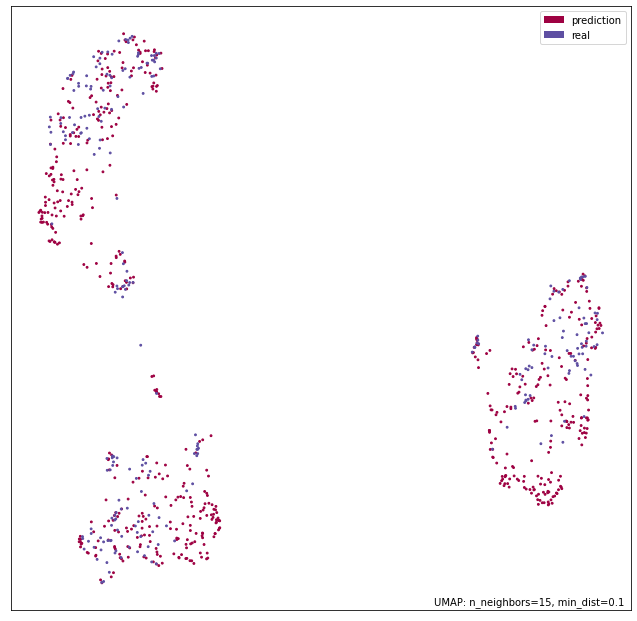

In [87]:
import umap
import umap.plot


reducer = umap.UMAP()
data = torch.cat([preds, reals], dim=0).detach().numpy()
lbls = ['prediction' for _ in range(preds.shape[0])]
lbls = lbls + ['real' for _ in range(reals.shape[0])]
labels = torch.cat([torch.zeros(preds.shape[0]), torch.ones(reals.shape[0])])
mapper = reducer.fit(data)
umap.plot.points(mapper, labels=np.array(lbls), background='white')

In [73]:
p = umap.plot.interactive(mapper, labels=lbls, point_size=2)
umap.plot.show(p)